# 第十二週: BERT (Encoder-only-model)
第二組
<br>
使用電動車資料集實作BERT (Encoder-only-model)，包含Token classification、Sequence classification 以及 Text Clustering
1. 載入套件
2. 資料前處理
3. Token classification<br>
  NER<br>
4. Sequence classification<br>
  Sentiment Classification<br>
5. Text Clustering<br>
  BERTopic 用於中文資料集<br>

### 1. 載入套件

連接雲端資料夾

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/SMA_2024S-main/week12') # 請將這行修改為自己的 google drive 路徑
os.listdir() # 確認目錄內容

Mounted at /content/drive


['week12_bert.ipynb', 'TaipeiSansTCBeta-Regular.ttf', 'raw_data', 'dict']

前處理常用套件

In [ ]:
# !pip install jieba

In [2]:
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 設定字體
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

transformers 和 Sentence-transformers （使用 huggingface 模型）

In [4]:
!pip install sentence_transformers
!pip install ckip_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [5]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

BERTopic

In [7]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [8]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

### 2. 資料前處理

載入電動車資料集

In [9]:
# 讀入資料集
origin_data = pd.read_csv('./raw_data/EV_2023_2024.csv')

處理資料

In [43]:
# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/car/M.1684536513.A.C23....,[問題]油電車少開、中古相關問題(UX.CT.IS),2023-05-20 06:48:31,近期在找Lexus二手車，綜觀預算、\n車高1550限制、外型喜好，可能IS、CT、UX ...,近期在找二手車
1,1,https://www.ptt.cc/bbs/car/M.1684536513.A.C23....,[問題]油電車少開、中古相關問題(UX.CT.IS),2023-05-20 06:48:31,近期在找Lexus二手車，綜觀預算、\n車高1550限制、外型喜好，可能IS、CT、UX ...,綜觀預算車高限制外型喜好
2,1,https://www.ptt.cc/bbs/car/M.1684536513.A.C23....,[問題]油電車少開、中古相關問題(UX.CT.IS),2023-05-20 06:48:31,近期在找Lexus二手車，綜觀預算、\n車高1550限制、外型喜好，可能IS、CT、UX ...,可能三選一
3,1,https://www.ptt.cc/bbs/car/M.1684536513.A.C23....,[問題]油電車少開、中古相關問題(UX.CT.IS),2023-05-20 06:48:31,近期在找Lexus二手車，綜觀預算、\n車高1550限制、外型喜好，可能IS、CT、UX ...,使用上短程
4,1,https://www.ptt.cc/bbs/car/M.1684536513.A.C23....,[問題]油電車少開、中古相關問題(UX.CT.IS),2023-05-20 06:48:31,近期在找Lexus二手車，綜觀預算、\n車高1550限制、外型喜好，可能IS、CT、UX ...,市區假日用平均一個月開不到
...,...,...,...,...,...,...
60195,1974,https://www.ptt.cc/bbs/car/M.1716203453.A.734....,[新聞]馬斯克頭痛了！特斯拉賣不掉租「廢棄購,2024-05-20 19:10:46,[新聞](需檢附來源)\nhttps://is.gd/xdS3Qe\n馬斯克頭痛了！特斯拉賣...,附註心得說明有點像台灣之前電動機車一樣
60196,1974,https://www.ptt.cc/bbs/car/M.1716203453.A.734....,[新聞]馬斯克頭痛了！特斯拉賣不掉租「廢棄購,2024-05-20 19:10:46,[新聞](需檢附來源)\nhttps://is.gd/xdS3Qe\n馬斯克頭痛了！特斯拉賣...,熱潮過了
60197,1974,https://www.ptt.cc/bbs/car/M.1716203453.A.734....,[新聞]馬斯克頭痛了！特斯拉賣不掉租「廢棄購,2024-05-20 19:10:46,[新聞](需檢附來源)\nhttps://is.gd/xdS3Qe\n馬斯克頭痛了！特斯拉賣...,銷售就大降了
60198,1974,https://www.ptt.cc/bbs/car/M.1716203453.A.734....,[新聞]馬斯克頭痛了！特斯拉賣不掉租「廢棄購,2024-05-20 19:10:46,[新聞](需檢附來源)\nhttps://is.gd/xdS3Qe\n馬斯克頭痛了！特斯拉賣...,看起來售價還有機會大幅度調整


### 3. Token classification

#### NER

使用 CKIP 開發的 NLP 套件：ckip_transformers<br>
使用的 WS 模型：https://huggingface.co/ckiplab/bert-base-chinese-ws<br>
使用的 POS 模型：https://huggingface.co/ckiplab/bert-base-chinese-pos<br>
使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [11]:
# 初始化 ckip 工具
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0)
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0)
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0)

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.86k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Inference: 100%|██████████| 1/1 [00:00<00:00, 48.12it/s]


套用到處理好的資料集
考慮到資料筆數太大，使用一半的資料集進行

In [14]:
text = metaData['sentence'].iloc[:len(metaData)//2].tolist()

# 執行
ws = ws_driver(text)
pos = pos_driver(ws)
ner = ner_driver(text)

# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})")
   return "\u3000".join(res)

sentences, packed_sentences, entities = [], [], []

# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results


Inference: 100%|██████████| 115/115 [14:29<00:00,  7.56s/it]


,sentence,packed_sentence,entities
0,近期在找二手車,近期(Nd) 在(P) 找(VC) 二手車(Na),[]
1,綜觀預算車高限制外型喜好,綜觀(VC) 預算(Na) 車高(Na) 限制(Na) 外型(Na) 喜好(VL),[]
2,可能三選一,可能(D) 三(Neu) 選(VC) 一(Neu),"[NerToken(word='三選一', ner='CARDINAL', idx=(2, ..."
3,使用上短程,使用(VC) 上(Ng) 短程(Na),[]
4,市區假日用平均一個月開不到,市區(Nc) 假日(Nd) 用(P) 平均(VH) 一(Neu) 個(Nf) 月(Na) 開...,"[NerToken(word='一個月', ner='DATE', idx=(7, 10))]"
...,...,...,...
30095,順順開的話左右換完胎寬的胎後,順順(VH) 開(VC) 的話(DE) 左右(Ncd) 換完(VC) 胎(Na) 寬(VH)...,[]
30096,熱血開的話約左右,熱血(Na) 開(VC) 的話(Cba) 約(Da) 左右(Ng),[]
30097,順順開的話左右,順順(VH) 開(VC) 的(Cba) 話(Na) 左右(Ng),[]
30098,有些人會有疑問如果家裡不能充電,有(V_2) 些(Nf) 人(Na) 會(D) 有(V_2) 疑問(Na) 如果(Cbb) ...,[]


### 4. Sequence classification

#### Sentiment Classification
使用 Huggingface 上面已經針對 Sentiment classification 任務 finetune 的 BERT 模型來實作<br>
使用的模型：https://huggingface.co/techthiyanes/chinese_sentiment<br><br>
情緒：<br>
1: Semi-negation<br>
2: Negation<br>
3: Neutral<br>
4: Semi-positive<br>
5: Positive

In [49]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"  # 你可以將這裡換成你想要使用的模型
model = pipeline('sentiment-analysis', model=model_name)


In [45]:
# 建立一個新的 dataframe 來儲存結果
results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
# 按 'artTitle' 分組
grouped = metaData.groupby('artTitle')

# 隨機選擇五篇文章
random_titles = grouped.apply(lambda x: x.name).sample(n=5, random_state=42)

# 篩選出這五篇文章的所有句子
random_articles = metaData[metaData['artTitle'].isin(random_titles)]
# 顯示隨機選擇的五篇文章的資料
print(random_articles)

       system_id                                             artUrl  \
3804         124  https://www.ptt.cc/bbs/car/M.1686631485.A.64A....   
3805         124  https://www.ptt.cc/bbs/car/M.1686631485.A.64A....   
3806         124  https://www.ptt.cc/bbs/car/M.1686631485.A.64A....   
3807         124  https://www.ptt.cc/bbs/car/M.1686631485.A.64A....   
3808         124  https://www.ptt.cc/bbs/car/M.1686631485.A.64A....   
...          ...                                                ...   
56284       1826  https://www.ptt.cc/bbs/car/M.1713934082.A.6B7....   
56285       1826  https://www.ptt.cc/bbs/car/M.1713934082.A.6B7....   
56286       1826  https://www.ptt.cc/bbs/car/M.1713934082.A.6B7....   
56287       1826  https://www.ptt.cc/bbs/car/M.1713934082.A.6B7....   
56288       1826  https://www.ptt.cc/bbs/car/M.1713934082.A.6B7....   

                       artTitle              artDate  \
3804    Re:[電車]平價品牌的電車售價未來應該多少？  2023-06-13 12:44:42   
3805    Re:[電車]平價品牌的電車售價未來應該多少？  20

In [48]:
# 建立一個新的 dataframe 來儲存結果
results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
results_df['sentence'] = random_articles['sentence']

# 定義一個函數來進行情緒分析
def analyze_sentiment(sentence):
    result = model([sentence])
    return pd.Series([result[0]['label'], result[0]['score']])

# 使用 apply 函數來進行情緒分析
results_df[['label', 'score']] = random_articles['sentence'].apply(analyze_sentiment)

# 輸出結果
results_df

,sentence,label,score
3804,去年中國汽車外銷數量超越豐田成為全球第一多是電動車,star 4,0.371049
3805,中國電動車含特斯拉售價大量落在萬人民幣,star 3,0.292424
3806,台灣不允許中國產品與服務進口,star 1,0.588173
3807,特斯拉在台灣沒有對手不可能降價,star 4,0.306813
3808,所以有可能台灣會是世界上電車普及率最低以及售價最貴的國家,star 4,0.470782
...,...,...,...
56284,隨著電動車輕量化得需求鎂合金因為單位重量的強度優於鋁合金而越來越被重視,star 4,0.582920
56285,比強度單位重量強度壓鑄成型鋁合金鎂合金半固態成型,star 4,0.431031
56286,也就是在同樣強度下鎂合金有左右的重量降低空間,star 3,0.412784
56287,下一代的電動車可能越來越多鎂合金包含車體,star 4,0.401072


可以依據前幾週的程式碼，對情緒分析後的句子進行近一步的探索

### 5. Text Clustering

#### BERTopic 中文<br>
使用前500筆資料

In [17]:
# 中文文章
docs_zh = metaData['sentence'].tolist()[:500]

# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2024-05-27 12:14:55,592 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-27 12:15:05,584 - BERTopic - Dimensionality - Completed ✓
2024-05-27 12:15:05,588 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-27 12:15:05,650 - BERTopic - Cluster - Completed ✓
2024-05-27 12:15:05,659 - BERTopic - Representation - Extracting topics from clusters using representation models.
Building prefix dict from /content/drive/MyDrive/SMA_2024S-main/week12/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/SMA_2024S-main/week12/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.uee530161ad203c4c2c65081c335e6b92.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.uee530161ad203c4c2c65081c335e6b92.cache
Loading model cost 2.291 seconds.
DEBUG:jieba:Loading model cost 2.291 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
2024-05-27 12:15:08,062 - BERT

,Topic,Count,Name,Representation,Representative_Docs
0,-1,94,-1_ _電動車_車主_樁,"[ , 電動車, 車主, 樁, 險, 特斯拉, 充電, 電車, 中國, 保險公司, 車體, ...","[電動車車主在安裝充電樁時, 因為比起電動車, 超過九成以上的理賠率保險公司現在還願意大發慈..."
1,0,197,0_ _氫_電車_買,"[ , 氫, 電車, 買, 充電, 油車, 想, 補貼, 電池, 說, 電動車, 氫能, 車...",[以後應該是不用擔心電動車不能保丙或是拒保只是會適用不同費率但有的保險公司可能還會利用強制加...
2,1,75,1_軟體_駕駛_ _自動,"[軟體, 駕駛, , 自動, 特斯拉, 平臺, 優步, 新, 福斯, 集團, 擁有, 發表...","[其只需要安裝公司的自動駕駛軟體, 特斯拉的自動駕駛軟體被廣泛認為是業內最先進的系統之一, ..."
3,2,61,2_ _說_人士_謝謝,"[ , 說, 人士, 謝謝, 郭建盟, 台灣, 暫, 特色, 為限, 月份, 數落, 皆知,...","[他說, 相關人士說, 知情人士說]"
4,3,33,3_同意_管理_委員會_管委會,"[同意, 管理, 委員會, 管委會, , 管理條例, 公寓, 大樓, 技師, 未經, 私設...","[讓車主誤以為未經管理委員會同意的表後接線行為, 必須經過管理負責人或管理委員會的同意, 只..."
5,4,25,4_產險_車險_電動車_公會,"[產險, 車險, 電動車, 公會, , 投保, 研議, 傳統, 保險公司, 車主, 未來,...","[而在產險公會組成工作小組研議電動車險後, 電動車車主未來想保車險將不再適用傳統的油車險, ..."
6,5,15,5_充電_大樓_設置_樁,"[充電, 大樓, 設置, 樁, 供電, 補助, 設備, 大廈, 公寓, 用電, , 空間,...","[所以住戶們無需擔心因充電樁的使用導致大樓用電不足的問題, 既有公寓大廈住戶於公寓大廈設置電..."


In [23]:
zh_topic_model.visualize_topics()

查看特定文章的主題分佈

In [24]:
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


查看第15篇文章主題分布

In [38]:
zh_topic_model.visualize_distribution(topic_distr[15])

查看第四個主題，發現是與電動車保險相關

In [30]:
zh_topic_model.get_topic(4)

[('產險', 0.16416866276233144),
 ('車險', 0.163174817217169),
 ('電動車', 0.121641465587646),
 ('公會', 0.1049606804776361),
 (' ', 0.097414445467375),
 ('投保', 0.09454028856785388),
 ('研議', 0.08915420713929788),
 ('傳統', 0.08498574089430436),
 ('保險公司', 0.07624256372209649),
 ('車主', 0.07488815757656533),
 ('未來', 0.07406166475807861),
 ('一併', 0.06809906549914854),
 ('個案', 0.06809906549914854),
 ('損失率', 0.06809906549914854),
 ('核保', 0.06809906549914854),
 ('承保', 0.06809906549914854),
 ('專險', 0.06302685904523592),
 ('業者', 0.06302685904523592),
 ('小組', 0.06302685904523592),
 ('理賠', 0.06302685904523592),
 ('保費', 0.05943613809286526),
 ('拒保', 0.05665716059620291),
 ('費率', 0.05439160573905634),
 ('貴', 0.05439160573905634),
 ('特斯拉', 0.054063593503599),
 ('車款', 0.050828375814731),
 ('險', 0.04807670814968754),
 ('想保', 0.03839492599003135),
 ('訂定', 0.03839492599003135),
 ('精算', 0.03839492599003135)]

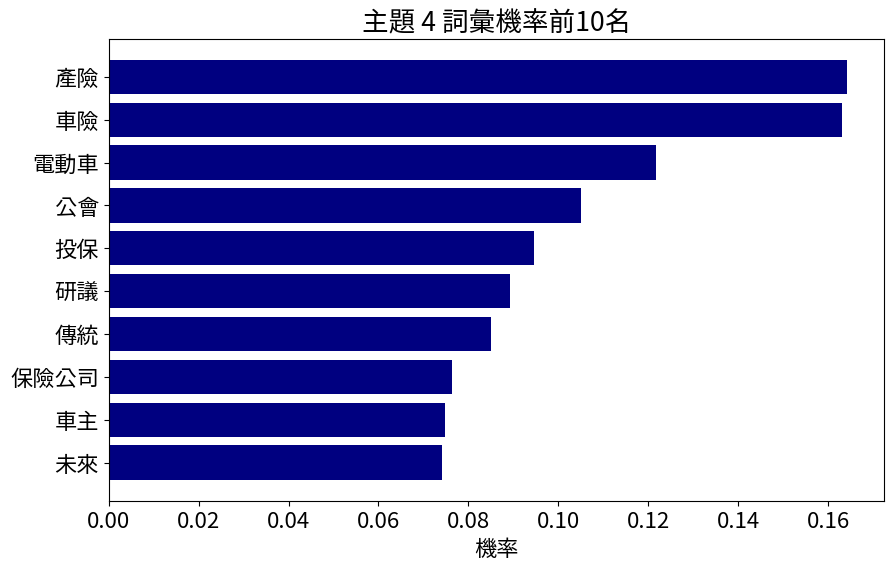

In [31]:
# 視覺化顯示主題-詞彙分佈
topic_n = 4
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()